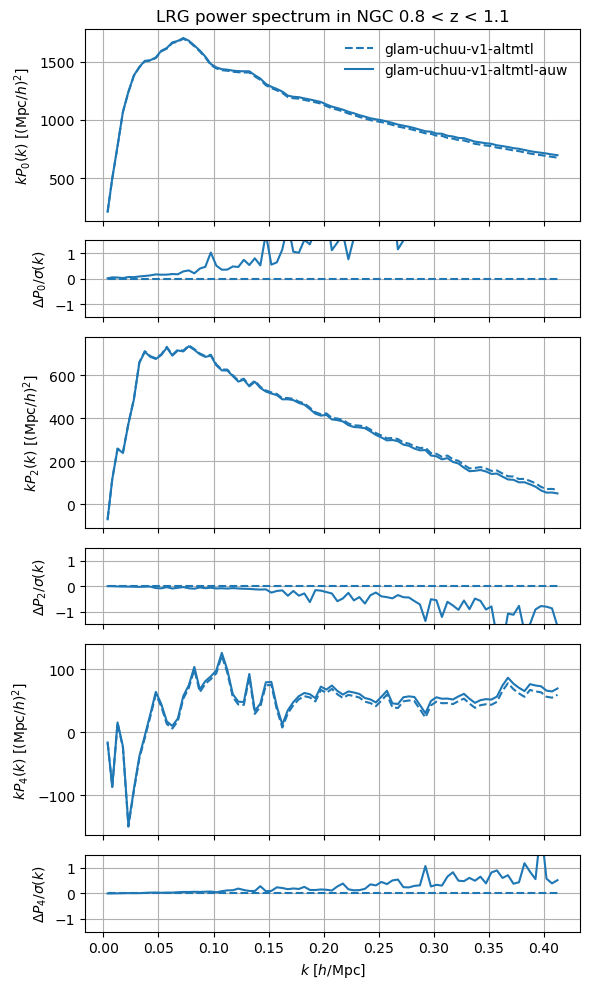

In [10]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types
sys.path.insert(0, '../')
import tools

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

ext = 'png'

region = 'NGC'
tracers = [('LRG', (0.8, 1.1))]

versions = {'glam-uchuu-v1-altmtl': {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default', 'cut': False, 'auw': False},
           'glam-uchuu-v1-altmtl-auw': {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default', 'cut': False, 'auw': True}}


colors = dict(zip(versions, ['C0', 'C0', 'C1']))
linestyles = dict(zip(versions, ['--', '-', '-']))
kinds = ['mesh2_spectrum']
#kinds = ['auw']

meas_dir = Path(os.getenv('SCRATCH')) / 'glam-uchuu_mocks_validation'


for tracer, zrange in tracers:

    for kind in kinds:

        if 'mesh2_spectrum' in kind:
            kind = 'mesh2_spectrum_poles'
            rebin = 5

            def get_means_covs():
                means, covs = {}, {}
                for version in versions:
                    _tracer = tracer
                    _version, _weight, _cut, _auw = (versions[version][name] for name in ['version', 'weight', 'cut', 'auw'])
                    if 'complete' in version and 'ELG' in tracer:
                        _tracer = 'ELG_LOP'
                    fns = tools.get_measurement_fn(kind=kind, meas_dir=meas_dir, version=_version, tracer=_tracer, zrange=zrange, region=region, cut=_cut, auw=_auw, weight=_weight, imock='*')
                    stats = list(map(types.read, fns))
                    means[version] = types.mean(stats).select(k=slice(0, None, rebin))#.select(k=(0., 0.3))
                    if len(stats) > 1:
                        covs[version] = types.cov(stats).at.observable.match(means[version])
                    else:
                        covs[version] = None
                return means, covs

            means, covs = get_means_covs()
            versions = list(means)
            ells = means[versions[0]].ells
            #ells = [2]

            fig, lax = plt.subplots(len(ells) * 2, figsize=(6, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1] * len(ells)})
            lax[0].set_title(f'{tracer} power spectrum in {region} {zrange[0]:.1f} < z < {zrange[1]:.1f}')
            for ill, ell in enumerate(ells):
                ax = lax[2 * ill]
                ax.set_ylabel(rf'$k P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
                for iversion, version in enumerate(versions):
                    pole = means[version].get(ell)
                    ax.plot(pole.coords('k'), pole.coords('k') * pole.value().real, color=colors[version], linestyle=linestyles[version], label=version)
                if ill == 0: ax.legend(frameon=False, ncol=1)
                ax.grid(True)
                ax = lax[2 * ill + 1]
                ax.set_ylabel(rf'$\Delta P_{ell:d} / \sigma(k)$')
                ax.grid(True)
                ax.set_ylim(-1.5, 1.5)
                for iversion, version in enumerate(versions):
                    pole = means[version].get(ell)
                    std = covs[version].at.observable.get(ell).std().real
                    #ax.plot(pole.coords('k'), (pole.value() - means[version.replace('altmtl', 'complete')].get(ell).value()).real / std, color=colors[version], linestyle=linestyles[version])
                    ax.plot(pole.coords('k'), (pole.value() - means[version.replace('-auw', '')].get(ell).value()).real / std, color=colors[version], linestyle=linestyles[version])
            lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
            basename = f'uchuu-glam_mocks_validation_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
            plt.tight_layout()
            fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
            plt.show()